# Deeplearning for deforrestation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import warnings
import random
import keras
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense,BatchNormalization
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import keras.callbacks as cbks
import keras_metrics
from keras import backend as K
import pandas as pd
%matplotlib inline


Using TensorFlow backend.


# Load data sets except test forrest

In [162]:
testDataArea=1
for i in range(14):
    if i ==0:
        df=pd.read_csv('model files/subset'+str(i)+'.csv')
    elif i!=testDataArea:
        newDf=pd.read_csv('model files/subset'+str(i)+'.csv')
        print(i,len(newDf))
        df=pd.concat([df,newDf])
print(len(df))

2 9100
3 8640
4 5963
5 3456
6 2392
7 17955
8 1932
9 1254
10 1254
11 1326
12 4096
13 2756
83719


# Load test forrest

In [101]:
testArea=pd.read_csv('model files/subset'+str(1)+'.csv')

# Set label and remove redundant columns

In [76]:
df['label']=df['2018 10 km2']


In [77]:
for i in range(10):
    df=df.drop([str(2019)+' '+str(i*10)+' '+'km2'],axis=1)
for i in range(10):
    df=df.drop([str(2018)+' '+str(i*10)+' '+'km2'],axis=1)
df=df.drop(['Unnamed: 0'],axis=1)

# Data frame to be used

In [78]:
df.describe()

,2015 0 km2,2015 10 km2,2015 20 km2,2015 30 km2,2015 40 km2,2015 50 km2,2015 60 km2,2015 70 km2,2015 80 km2,2015 90 km2,...,2017 10 km2,2017 20 km2,2017 30 km2,2017 40 km2,2017 50 km2,2017 60 km2,2017 70 km2,2017 80 km2,2017 90 km2,label
count,83719.000000,83719.000000,83719.000000,83719.000000,83719.000000,83719.000000,83719.000000,83719.000000,83719.000000,83719.00000,...,83719.000000,83719.000000,83719.00000,83719.000000,83719.000000,83719.00000,83719.000000,83719.000000,83719.000000,83719.000000
mean,17.728735,1747.520897,6761.082896,14533.653185,24423.508152,35650.695266,47648.938234,59913.321635,71977.522570,83691.62969,...,892.270285,3487.527037,7595.47749,12978.962756,19319.444702,26303.51373,33597.622320,40930.622021,48181.135429,622.701812
std,77.478950,3499.852076,10354.138748,19139.042845,29067.592270,39312.612075,49412.890658,58987.752944,67626.306784,75299.12848,...,1449.668411,4193.421386,7904.63616,12121.529555,16483.250387,20764.50418,24827.252579,28606.572954,32064.816632,1042.864940
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,452.000000,0.000000
25%,0.000000,29.000000,789.500000,2917.000000,6840.500000,12509.000000,18949.000000,25035.000000,30347.000000,34531.50000,...,14.000000,469.000000,1792.00000,3681.000000,6562.500000,10208.50000,14554.500000,19316.000000,22855.000000,8.000000
50%,0.000000,607.000000,3372.000000,8704.000000,15605.000000,23543.000000,32196.000000,42469.000000,48801.000000,58835.00000,...,363.000000,2039.000000,4937.00000,9444.000000,15487.000000,21463.00000,27012.000000,34450.000000,40049.000000,257.000000
75%,6.000000,1971.500000,8498.000000,18548.000000,31296.000000,43176.000000,58168.500000,74232.500000,90159.500000,105884.00000,...,1158.000000,4891.000000,11110.50000,18626.000000,27305.000000,37005.00000,48385.000000,60775.500000,72144.500000,840.000000
max,1592.000000,53854.000000,85559.000000,144636.000000,209007.000000,264666.000000,309619.000000,366324.000000,394691.000000,402416.00000,...,17291.000000,29262.000000,53551.00000,68272.000000,90258.000000,113423.00000,127770.000000,136840.000000,141917.000000,18313.000000


# Prepair train data

In [79]:
trainDat=df.drop(['label','coordinate'],axis=1)

In [ ]:
#normalize
trainDat=(trainDat-trainDat.mean())/trainDat.std()

# Make 3d matrix

In [83]:

seq = trainDat.reindex(sorted(trainDat.columns), axis=1)
seqList=[]
noOfFeatures=10
for row in seq.as_matrix():
    seqFeat=[]
    for i in range(int(len(row)/noOfFeatures)):
        tmpFeat=[]
        for no in range(noOfFeatures):
            tmpFeat.append(row[no+i*10])
        seqFeat.append(tmpFeat)
    seqList.append(seqFeat)
seqArr=np.array(seqList)

# Init model

In [92]:
def init_lstm(seqArr,windowSize,featureSize):
    model = Sequential()

    model.add(LSTM(
             input_shape=(windowSize, featureSize),
             units=8,
             return_sequences=True))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(LSTM(
              units=4,
              return_sequences=False))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    print(model.summary())
    return model

windowSize=3
featureSize=10
lstmMod=init_lstm(seqArr,windowSize,featureSize)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 8)              608       
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 8)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 8)              32        
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4)                 16        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total para

In [93]:
def convertToCat(x):
    new=np.zeros(4)
    new[x]=1
    return list(new)

# Train/validation

In [98]:
import random
batch_size=32
epochs=30
# df['label']=df['label'].apply(lambda x: convertToCat(x))
trainX=seqArr[0:int(0.8*seqArr.shape[0]),:,:]
trainY=df['label'][0:int(0.8*seqArr.shape[0])]
valX=seqArr[int(0.8*seqArr.shape[0]):seqArr.shape[0],:,:]
valY=df['label'][int(0.8*seqArr.shape[0]):seqArr.shape[0]]


In [99]:
#trail model and save best
checkpointer = cbks.ModelCheckpoint(filepath='weights.hdf5',monitor='val_loss' ,verbose=1, save_best_only=True,mode='min')

history_callback=lstmMod.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=[valX,valY], verbose=1
          ,callbacks = [checkpointer],shuffle=True)
fileName="model"
model_json= lstmMod.to_json()
with open(fileName+".json", "w") as json_file:
            json_file.write(model_json)
            print('`run_seq_model` > model saved : '+fileName+'.json')

Train on 66975 samples, validate on 12558 samples
Epoch 1/30
66975/66975 [==============================] - 14s 205us/step - loss: 670845.2596 - mean_absolute_error: 472.7028 - val_loss: 248745.7927 - val_mean_absolute_error: 392.3317

Epoch 00001: val_loss improved from inf to 248745.79266, saving model to weights.hdf5
Epoch 2/30
66975/66975 [==============================] - 14s 207us/step - loss: 665969.8368 - mean_absolute_error: 470.4444 - val_loss: 267113.7091 - val_mean_absolute_error: 375.5048

Epoch 00002: val_loss did not improve from 248745.79266
Epoch 3/30
66975/66975 [==============================] - 14s 205us/step - loss: 656056.5979 - mean_absolute_error: 470.2909 - val_loss: 191621.5108 - val_mean_absolute_error: 344.4249

Epoch 00003: val_loss improved from 248745.79266 to 191621.51084, saving model to weights.hdf5
Epoch 4/30
66975/66975 [==============================] - 14s 205us/step - loss: 647756.5037 - mean_absolute_error: 467.7359 - val_loss: 170306.9518 - val_

KeyboardInterrupt: 

In [100]:
# load json and create model
def load_model(filname):
    json_file = open("model"+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model)
    print('`load_seq_model` > model and weights loaded : ', fileName)
model=load_model("model 14_4.hdf5")

`run_seq_model` > model saved : model.json
`load_seq_model` > model and weights loaded :  model


# Test on test forrest

In [124]:
feat=testArea.drop(['coordinate'],axis=1)

In [125]:
coord=testArea['coordinate']

In [126]:
testArea['label']=testArea['2018 10 km2']

label=testArea['label']

In [149]:
orig=testArea['2017 10 km2']

In [129]:
for i in range(10):
    feat=feat.drop([str(2019)+' '+str(i*10)+' '+'km2'],axis=1)
for i in range(10):
    feat=feat.drop([str(2018)+' '+str(i*10)+' '+'km2'],axis=1)
feat=feat.drop(['Unnamed: 0'],axis=1)


In [130]:
feat=(feat-feat.mean())/feat.std()

In [132]:
seq = feat.reindex(sorted(feat.columns), axis=1)
seqList=[]
noOfFeatures=10
for row in seq.as_matrix():
    seqFeat=[]
    for i in range(int(len(row)/noOfFeatures)):
        tmpFeat=[]
        for no in range(noOfFeatures):
            tmpFeat.append(row[no+i*10])
        seqFeat.append(tmpFeat)
    seqList.append(seqFeat)
seqArr=np.array(seqList)

C:\Users\larsr\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Predict scores

In [133]:
pred=loaded_model.predict(seqArr)
difs=[]


In [150]:

coord=pd.DataFrame(coord)
coord['prediction']=pred
coord['real']=label
coord['orig']=orig

In [136]:

coord['x']=coord['coordinate'].apply(lambda x:int(x.split(',')[0][1:]))
coord['y']=coord['coordinate'].apply(lambda x:int(x.split(',')[1][0:len(x.split(',')[1])-1]))

# Visualize results on map

In [137]:
grid=np.zeros((max(coord['x'])+1,max(coord['y'])+1))

In [138]:
for row in coord[['x','y','real','prediction']].as_matrix():
    grid[int(row[0])][int(row[1])]=int(row[3])

C:\Users\larsr\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


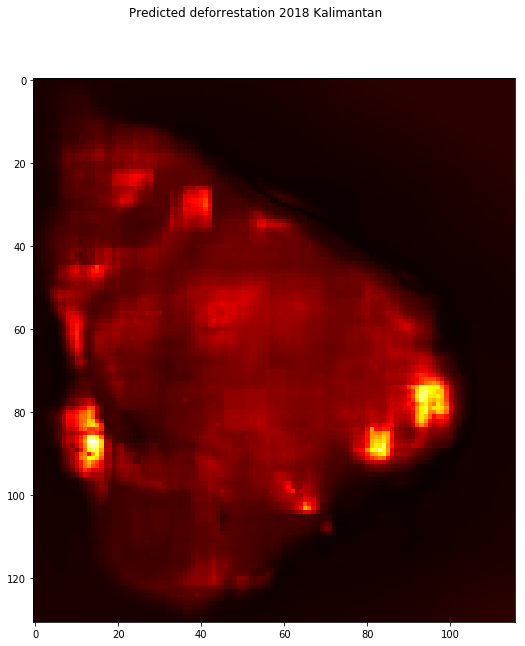

In [161]:
plt.figure(figsize=(20,10))
plt.suptitle("Predicted deforrestation 2018 Kalimantan")
plt.imshow(grid, cmap='hot')
plt.show()

In [140]:
grid2=np.zeros((max(coord['x'])+1,max(coord['y'])+1))

In [141]:
for row in coord[['x','y','real','prediction']].as_matrix():
    grid2[int(row[0])][int(row[1])]=int(row[2])

C:\Users\larsr\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


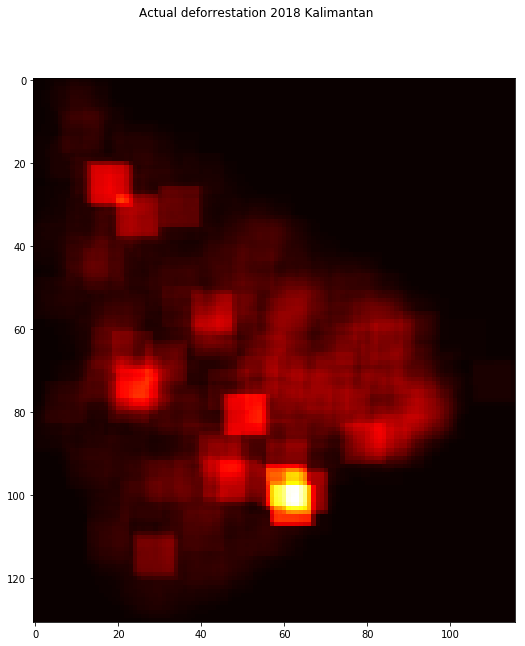

In [159]:
plt.figure(figsize=(20,10))
plt.suptitle("Actual deforrestation 2018 Kalimantan")

plt.imshow(grid2, cmap='hot')
plt.show()

In [151]:
grid3=np.zeros((max(coord['x'])+1,max(coord['y'])+1))

In [152]:
for row in coord[['x','y','orig']].as_matrix():
    grid3[int(row[0])][int(row[1])]=int(row[2])

C:\Users\larsr\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


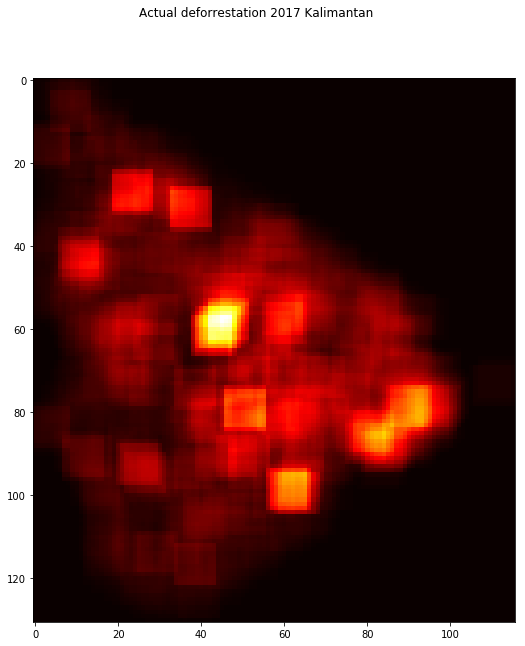

In [160]:
plt.figure(figsize=(20,10))
plt.suptitle("Actual deforrestation 2017 Kalimantan")

plt.imshow(grid3, cmap='hot')
plt.show()

# Second architecture

In [ ]:
def init_model(seqArr,windowSize,featureSize):
    windowSize=seqArr.shape[1]
    featureSize=seqArr.shape[2]

    main_input = Input(shape=(windowSize, featureSize), dtype='float', name='main_input')
    lstm_out = LSTM(12,batch_input_shape=(windowSize, featureSize),return_sequences=False)(main_input)
    lstm_out=Dropout(0.3)(lstm_out)
    lstm_out=BatchNormalization()(lstm_out)
#     lstm_out=BatchNormalization()(lstm_out)

#     lstm_out = LSTM(32,return_sequences=False)(lstm_out)
#     lstm_out=Dropout(0.3)(lstm_out)

#     lstm_out=BatchNormalization()(lstm_out)

    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)
    auxiliary_input = Input(shape=(len(statFeat[0]),), name='aux_input')
    x = keras.layers.concatenate([lstm_out, auxiliary_input],axis=-1) 
    x=Dense(16, activation="relu")(x)
    x=Dropout(0.3)(x)
    x=BatchNormalization()(x)
    x=Dense(8, activation="relu")(x)
    x=Dropout(0.3)(x)
    x=BatchNormalization()(x)
    main_output = Dense(1, activation="sigmoid", name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    model.compile(optimizer='rmsprop', loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.2},metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()])
#     model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001),)
    print(model.summary())
    return model

In [ ]:
seqArr.shape

In [ ]:
import random
batch_size=512
epochs=30
trainX=seqArr[0:int(0.8*seqArr.shape[0]),:,:]
trainY=tree_loss_df_norm['label'][0:int(0.8*seqArr.shape[0])]
testX=seqArr[int(0.8*seqArr.shape[0]):seqArr.shape[0],:,:]
testY=tree_loss_df_norm['label'][int(0.8*seqArr.shape[0]):seqArr.shape[0]]
statFeat=tree_loss_df_norm[['lat', 'long']].as_matrix()
statFeatTrain=statFeat[0:int(0.8*seqArr.shape[0]),:]
statFeatTest=statFeat[int(0.8*seqArr.shape[0]):seqArr.shape[0],:]

In [ ]:
model=init_model()
class_weight={0:1,
                 1:1000}
checkpointer = cbks.ModelCheckpoint(filepath='weights.hdf5',monitor='val_loss' ,verbose=1, save_best_only=True,mode='min')
results=model.fit([trainX,statFeatTrain],
                               [trainY,trainY],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([testX,statFeatTest],
                               [testY,testY]),shuffle=True,class_weight=class_weight)
